In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)
# https://www.tensorflow.org/tutorials/images/classification

2023-05-01 13:06:22.405999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [ ]:
import shutil
src_path = r"/home/fish/programing/cancerClassifier/patch_images/"
dst_path = r"/home/fish/programing/cancerClassifier/splitData/"

# split the dataset 
# dont runn unless you wanna split the data again (you dont)
with open('data_labels_mainData.csv', 'r') as file:
    
    for line in file.readlines()[1:]:
        li = line.split(',')
        shutil.copyfile(src_path + str(li[2]), dst_path + str(li[3]) + '/' + str(li[2]))
        print(li)
        



In [123]:
batch_size = 32
img_height = 27
img_width = 27

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names

Found 9896 files belonging to 4 classes.
Using 7917 files for training.
Found 9896 files belonging to 4 classes.
Using 1979 files for validation.


In [124]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [125]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[10]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

print(len(image_batch))

0.16078432 1.0
32


2023-04-26 13:42:15.799745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7917]
	 [[{{node Placeholder/_0}}]]
2023-04-26 13:42:15.799989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7917]
	 [[{{node Placeholder/_0}}]]


In [141]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])


In [142]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [143]:
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_34 (Rescaling)    (None, 27, 27, 3)         0         
                                                                 
 conv2d_54 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 6, 6, 128)       

In [144]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
248/248 [==============================] - 3s 10ms/step - loss: 0.9684 - accuracy: 0.5992 - val_loss: 0.9314 - val_accuracy: 0.6215
Epoch 2/10
248/248 [==============================] - 2s 10ms/step - loss: 0.7675 - accuracy: 0.6957 - val_loss: 0.6810 - val_accuracy: 0.7408
Epoch 3/10
248/248 [==============================] - 2s 10ms/step - loss: 0.6984 - accuracy: 0.7226 - val_loss: 0.7383 - val_accuracy: 0.7039
Epoch 4/10
248/248 [==============================] - 3s 11ms/step - loss: 0.6748 - accuracy: 0.7380 - val_loss: 0.7123 - val_accuracy: 0.7105
Epoch 5/10
248/248 [==============================] - 2s 10ms/step - loss: 0.6333 - accuracy: 0.7545 - val_loss: 0.6017 - val_accuracy: 0.7756
Epoch 6/10
248/248 [==============================] - 3s 10ms/step - loss: 0.5862 - accuracy: 0.7797 - val_loss: 0.6450 - val_accuracy: 0.7569
Epoch 7/10
248/248 [==============================] - 3s 10ms/step - loss: 0.5610 - accuracy: 0.7816 - val_loss: 0.6847 - val_accuracy: 0.7377

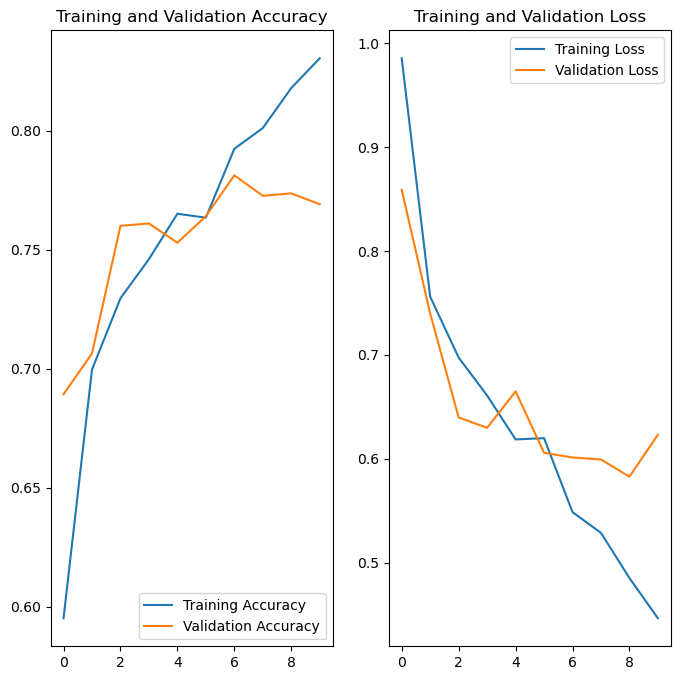

In [140]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Cancer Classifier

In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import imghdr

2023-05-07 08:10:36.801954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = '/Users/shehanjayaratne/Documents/RMIT programming/Machine Learning/Assignment 2/CancerousCells/'

In [3]:
os.listdir(data_dir)

['.DS_Store', 'Cancer', 'Non-cancer']

In [4]:
img =cv2.imread(os.path.join(data_dir,'Cancer','8820.png'))

In [5]:
type(img)

numpy.ndarray

In [6]:
img.shape

(27, 27, 3)

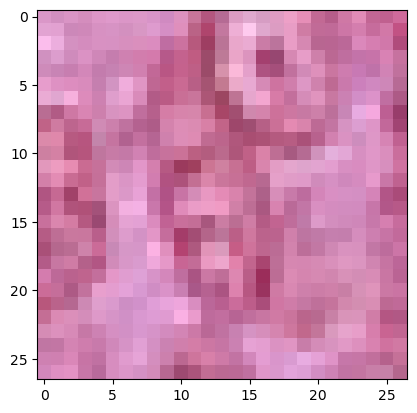

In [7]:
plt.imshow(img) 

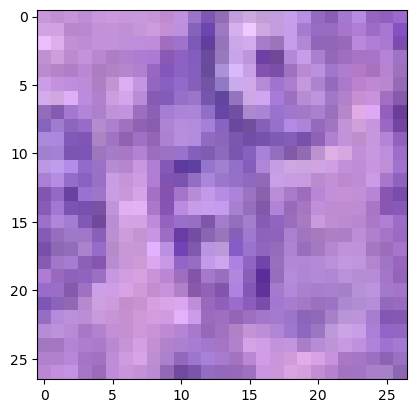

In [8]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
data = tf.keras.utils.image_dataset_from_directory(
    directory = data_dir,
    image_size = (27,27)
)

Found 9269 files belonging to 2 classes.


2023-05-07 08:10:55.472041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

In [12]:
batch

(array([[[[123.,  67., 134.],
          [165., 105., 165.],
          [205., 144., 200.],
          ...,
          [253., 222., 242.],
          [218., 169., 205.],
          [202., 147., 197.]],
 
         [[162.,  95., 160.],
          [217., 154., 211.],
          [212., 156., 206.],
          ...,
          [255., 228., 252.],
          [204., 151., 193.],
          [209., 157., 209.]],
 
         [[238., 177., 225.],
          [239., 178., 232.],
          [190., 131., 191.],
          ...,
          [241., 200., 231.],
          [195., 144., 186.],
          [225., 174., 224.]],
 
         ...,
 
         [[174., 149., 192.],
          [166., 131., 176.],
          [212., 168., 213.],
          ...,
          [236., 202., 230.],
          [235., 208., 230.],
          [255., 234., 251.]],
 
         [[229., 199., 226.],
          [205., 163., 204.],
          [240., 188., 245.],
          ...,
          [244., 223., 233.],
          [255., 241., 247.],
          [255., 248., 253.

In [13]:
batch[0].shape

(32, 27, 27, 3)

In [14]:
batch[0]/255

array([[[[0.48235294, 0.2627451 , 0.5254902 ],
         [0.64705884, 0.4117647 , 0.64705884],
         [0.8039216 , 0.5647059 , 0.78431374],
         ...,
         [0.99215686, 0.87058824, 0.9490196 ],
         [0.85490197, 0.6627451 , 0.8039216 ],
         [0.7921569 , 0.5764706 , 0.77254903]],

        [[0.63529414, 0.37254903, 0.627451  ],
         [0.8509804 , 0.6039216 , 0.827451  ],
         [0.83137256, 0.6117647 , 0.80784315],
         ...,
         [1.        , 0.89411765, 0.9882353 ],
         [0.8       , 0.5921569 , 0.75686276],
         [0.81960785, 0.6156863 , 0.81960785]],

        [[0.93333334, 0.69411767, 0.88235295],
         [0.9372549 , 0.69803923, 0.9098039 ],
         [0.74509805, 0.5137255 , 0.7490196 ],
         ...,
         [0.94509804, 0.78431374, 0.90588236],
         [0.7647059 , 0.5647059 , 0.7294118 ],
         [0.88235295, 0.68235296, 0.8784314 ]],

        ...,

        [[0.68235296, 0.58431375, 0.7529412 ],
         [0.6509804 , 0.5137255 , 0.6901961 ]

In [15]:
len(batch)

2

In [16]:
batch[1]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

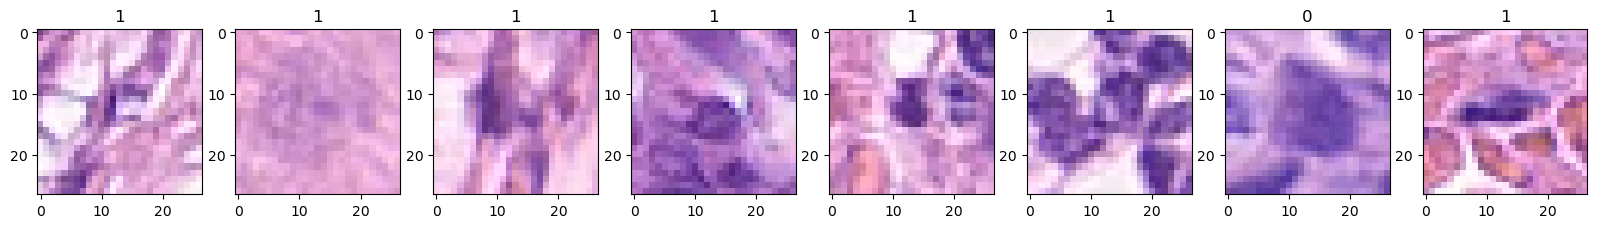

In [17]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
data = data.map(lambda x,y: (x/255,y))

In [19]:
data.as_numpy_iterator().next()[0].max()

1.0

In [20]:
len(data)

290

In [30]:
train_size = int(len(data)*.8)
test_size = int(len(data)*.2)
val_size = int(train_size * 0.25)
train_size -= val_size
print(train_size,val_size,test_size)

174 58 58


In [31]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+ val_size).take(test_size)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [39]:
model = Sequential()

In [40]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(27,27,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 25, 25, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 16)          4624      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 16)        

In [43]:
logdir = '/Users/shehanjayaratne/Documents/RMIT programming/Machine Learning/Assignment 2/logs/'

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir =logdir)

In [46]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/20
174/174 [==============================] - 2s 7ms/step - loss: 0.5566 - accuracy: 0.6952 - val_loss: 0.3441 - val_accuracy: 0.8675
Epoch 2/20
174/174 [==============================] - 1s 7ms/step - loss: 0.3409 - accuracy: 0.8542 - val_loss: 0.4152 - val_accuracy: 0.8184
Epoch 3/20
174/174 [==============================] - 1s 7ms/step - loss: 0.3180 - accuracy: 0.8644 - val_loss: 0.3012 - val_accuracy: 0.8718
Epoch 4/20
174/174 [==============================] - 1s 7ms/step - loss: 0.2927 - accuracy: 0.8806 - val_loss: 0.2863 - val_accuracy: 0.8836
Epoch 5/20
174/174 [==============================] - 1s 7ms/step - loss: 0.2763 - accuracy: 0.8865 - val_loss: 0.2970 - val_accuracy: 0.8712
Epoch 6/20
174/174 [==============================] - 1s 7ms/step - loss: 0.2715 - accuracy: 0.8870 - val_loss: 0.2854 - val_accuracy: 0.8793
Epoch 7/20
174/174 [==============================] - 1s 7ms/step - loss: 0.2702 - accuracy: 0.8865 - val_loss: 0.2719 - val_accuracy: 0.8825
Epoch 

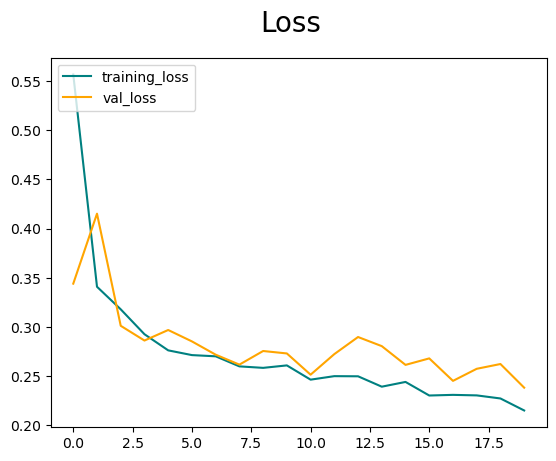

In [47]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='training_loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

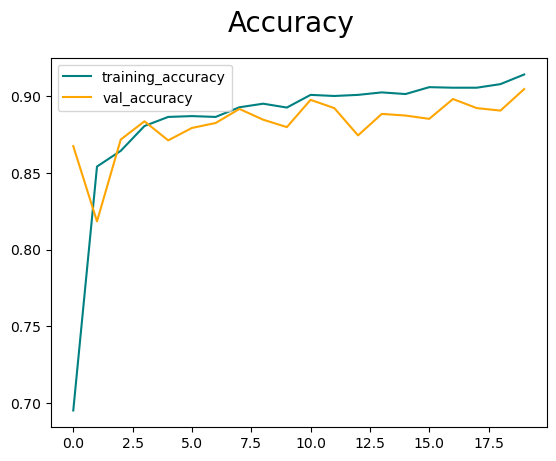

In [48]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='training_accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [49]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [50]:
len(test)

58

In [51]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [52]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 60ms/step


In [53]:
print(f'Precision:{pre.result()}, Recall:{re.result()}, Accuracy:{acc.result()}')

Precision:0.8863435983657837, Recall:0.9526515007019043, Accuracy:0.9029810428619385
